# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)

<a name=imports></a>
## Imports

In [542]:
%load_ext autoreload
%autoreload 2
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name=data></a>
## Data

### Ingestion
Load in the dataset as pandas dataframe.

In [544]:
# Check preprocessing.py for implementation
(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df) = preprocessing.ingestion()

Parent Directory /Users/vish/College/Year 3/Semester 5/Data Analytics/Project/covid19-prediction/models
Path: /Users/vish/College/Year 3/Semester 5/Data Analytics/Project/covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True
India Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-01-30        NaN     NaN        NaN
1  2020-01-31        0.0     0.0        0.0
2  2020-02-01        0.0     0.0        0.0
3  2020-02-02        1.0     0.0        0.0
4  2020-02-03        1.0     0.0        0.0 

India Vacc:
          Date  Total_Doses
0  2021-01-15          NaN
1  2021-01-16          NaN
2  2021-01-17      33120.0
3  2021-01-18     229748.0
4  2021-01-19     220786.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-12        NaN     NaN        NaN
1  2020-04-13    25255.0  1542.0    11785.0
2  2020-04-14    26694.0  2327.0     6484.0
3  2020-04-15    29318.0  2474.0     6093.0
4  2020-04-16    31235.0  4607.0     5234.0 

USA Vac

### Pre-Processing
Filter out unnecessary columns. 

#### Multivariate

In [545]:
# Check preprocessing.py for implementation
# Number of Null in India - 563
# Number of Null in USA - 261
(india_multi, usa_multi) = preprocessing.multivariate(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df)

India:
          Date  Confirmed  Total_Doses
0  2020-01-30        NaN          NaN
1  2020-01-31        0.0          NaN
2  2020-02-01        0.0          NaN
3  2020-02-02        1.0          NaN
4  2020-02-03        1.0          NaN
USA:
          Date  Confirmed  Total_Doses
0  2020-04-12        NaN          NaN
1  2020-04-13    25255.0          NaN
2  2020-04-14    26694.0          NaN
3  2020-04-15    29318.0          NaN
4  2020-04-16    31235.0          NaN


#### Univariate 

In [546]:
# Check preprocessing.py for implementation
# Number of Null in India - 0
# Number of Null in USA - 0
(india_cases_uni, usa_cases_uni) = preprocessing.univariate(india_cases_df, usa_cases_df)

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    25255.0
2    26694.0
3    29318.0
4    31235.0
5    32175.0 



### Drop Null
Merging the vaccination and #cases datasets together for multivariate time series produces null values. Dropping the nuWe solve this by dropping the null values.ll values ensures that we take an inner join.

In [547]:
(india_multi, usa_multi) = preprocessing.dropNull(india_multi, usa_multi)

India:
            Date  Confirmed  Total_Doses
353  2021-01-17    13788.0      33120.0
354  2021-01-18    10050.0     229748.0
355  2021-01-19    13816.0     220786.0
356  2021-01-20    15244.0     131649.0
357  2021-01-21    14545.0     237050.0
USA:
            Date  Confirmed  Total_Doses
253  2020-12-21   189716.0      57909.0
254  2020-12-22   201947.0     196954.0
255  2020-12-23   225777.0     196954.0
256  2020-12-24   204900.0     468280.0
257  2020-12-25   108685.0     234140.0


### Normalize
Perform a Z-score normalization.

In [548]:
# Check preprocessing.py for implementation
(india_uni_norm, usa_uni_norm, india_multi_norm, usa_multi_norm,india_cases_mean,india_cases_std,usa_cases_mean,usa_cases_std,india_multi_mean,india_multi_std,
usa_multi_mean, usa_multi_std) = preprocessing.normalize(india_cases_uni, 
                                                                                           usa_cases_uni, 
                                                                                           india_multi, 
                                                                                           usa_multi)

India Cases univariate:
    Confirmed
1  -0.662416
2  -0.662416
3  -0.662403
4  -0.662403
5  -0.662416 

USA Cases univariate:
    Confirmed
1  -0.596456
2  -0.584433
3  -0.562508
4  -0.546491
5  -0.538637 

India Cases multivariate:
      Confirmed  Total_Doses
353  -0.564210    -1.306870
354  -0.602772    -1.247747
355  -0.563921    -1.250442
356  -0.549190    -1.277244
357  -0.556401    -1.245551 

USA Cases multivariate:
      Confirmed  Total_Doses
253   0.524077    -0.977570
254   0.609261    -0.926634
255   0.775228    -0.926634
256   0.629828    -0.827240
257  -0.040273    -0.913012 



### Create Splits
Break the dataset into train and test. The current split is 80:20.

In [549]:
# Create train test splits
(india_uni_train, india_uni_test, usa_uni_train, usa_uni_test) = preprocessing.split(india_uni_norm, usa_uni_norm, 0.2)
(india_multi_train, india_multi_test, 
 usa_multi_train, usa_multi_test) = preprocessing.split(india_multi_norm, usa_multi_norm, 0.2)

India:
      Confirmed
1    -0.662416
2    -0.662416
3    -0.662403
4    -0.662403
5    -0.662416
..         ...
564  -0.332037
565  -0.200599
566  -0.184543
567  -0.182312
568  -0.210064

[568 rows x 1 columns] 

USA:
      Confirmed
1    -0.596456
2    -0.584433
3    -0.562508
4    -0.546491
5    -0.538637
..         ...
507   0.882933
508   0.655423
509   1.161010
510  -0.188293
511  -0.412010

[511 rows x 1 columns] 

India:
      Confirmed  Total_Doses
353  -0.564210    -1.306870
354  -0.602772    -1.247747
355  -0.563921    -1.250442
356  -0.549190    -1.277244
357  -0.556401    -1.245551
..         ...          ...
637  -0.558433     0.454255
638  -0.558794     1.464557
639  -0.574093     0.722069
640  -0.577353    -0.071408
641  -0.598924     0.193515

[278 rows x 2 columns] 

USA:
      Confirmed  Total_Doses
253   0.524077    -0.977570
254   0.609261    -0.926634
255   0.775228    -0.926634
256   0.629828    -0.827240
257  -0.040273    -0.913012
..         ...          ...
55

### Data Transformation
Simple conversion from pandas dataframe to numpy array by extracting the values.

In [550]:
# Univariate
india_uni_train_np, india_uni_test_np = india_uni_train.values,  india_uni_test.values
usa_uni_train_np, usa_uni_test_np = usa_uni_train.values, usa_uni_test.values
# Multivariate
india_multi_train_np, india_multi_test_np = india_multi_train.values,  india_multi_test.values
usa_multi_train_np, usa_multi_test_np = usa_multi_train.values, usa_multi_test.values

In [551]:
print(india_uni_train_np.shape, india_uni_test_np.shape)
print(india_multi_train_np.shape, india_multi_test_np.shape)

(568, 1) (143, 1)
(278, 2) (70, 2)


### Reshape
Converts the exiting train data set to match the input parameters of an LSTM (Samples, Time Steps, Features). The `lstm_data_transform()` method takes in 3 arguments: X data, y data and number of features.

We will be performing autoregression on the univariate data, therefore the X and y values are the same. As for the multivariate data, we will be using the confirmed column (index 0) as the y value.

In [552]:
india_uni_train_np

array([[-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62403204e-01],
       [-6.62403204e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62390076e-01],
       [-6.62416332e-01],
       [-6.62114388e-01],
       [-6.62390076e-01],
       [-6.62403204e-01],
       [-6.62376948e-01],
       [-6.62350692e-01],
       [-6.6

In [553]:
timesteps = 14

In [556]:
# Univariate
india_uni_train_X, india_uni_train_y = preprocessing.lstm_data_transform(india_uni_train_np, india_uni_train_np,
                                                                         timesteps)
usa_uni_train_X, usa_uni_train_y = preprocessing.lstm_data_transform(usa_uni_train_np, usa_uni_train_np,
                                                                     timesteps)
# Multivariate
india_multi_train_X, india_multi_train_y = preprocessing.lstm_data_transform(india_multi_train_np, india_multi_train_np, timesteps)
usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np, timesteps)
# usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np[:,0], timesteps)

In [557]:
print("Univariate India shape:",india_uni_train_X.shape, india_uni_train_y.shape)
print("Multivariate India shape:",india_multi_train_X.shape, india_multi_train_y.shape)

Univariate India shape: (554, 14, 1) (554, 1)
Multivariate India shape: (264, 14, 2) (264, 2)


The univariate array shape for the India dataset has 566 samples, 3 as the time step, and 1 feature for the X values. The y values is just the 566 samples.

Similarly, the multivariate array shape for the India dataset has 276 samples, 3 as the time step, and 2 features for the X values. The y values is just the 276 samples of the 0th column (Confirmed cases).

<a name=model></a>
## Model
We will define 4 models in total. One for the univariate data and another for the multivariate for each country.

In [558]:
import LSTMmodels
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [559]:
univariate_model_ind = LSTMmodels.build_lstm(time_steps=india_uni_train_X.shape[1],
                                             features=india_uni_train_X.shape[2])
univariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_uni_train_X.shape[1],
                                             features=usa_uni_train_X.shape[2])

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 100)               40800     
                                                                 
 dense_80 (Dense)            (None, 20)                2020      
                                                                 
 dense_81 (Dense)            (None, 1)                 21        
                                                                 
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 100)               40800     
                                                                 
 dense_82 (Dense)         

In [560]:
multivariate_model_ind = LSTMmodels.build_lstm(time_steps=india_multi_train_X.shape[1],
                                               features=india_multi_train_X.shape[2], outputs=2)
multivariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_multi_train_X.shape[1],
                                               features=usa_multi_train_X.shape[2], outputs=2)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 100)               41200     
                                                                 
 dense_84 (Dense)            (None, 20)                2020      
                                                                 
 dense_85 (Dense)            (None, 2)                 42        
                                                                 
Total params: 43,262
Trainable params: 43,262
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 100)               41200     
                                                                 
 dense_86 (Dense)         

<a name=train></a>
## Train 

In [561]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [562]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [563]:
# Train the model on univariate India dataset 
univariate_model_ind = LSTMmodels.train_model(univariate_model_ind,india_uni_train_X,india_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 2s 16ms/step - loss: 0.4067 - mae: 0.4067
Epoch 2/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1551 - mae: 0.1551
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1333 - mae: 0.1333
Epoch 4/300
18/18 [==============================] - 0s 11ms/step - loss: 0.1303 - mae: 0.1303
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1038 - mae: 0.1038
Epoch 6/300
18/18 [==============================] - 0s 11ms/step - loss: 0.0931 - mae: 0.0931
Epoch 7/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0823 - mae: 0.0823
Epoch 8/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0762 - mae: 0.0762
Epoch 9/300
18/18 [==============================] - 0s 10ms/step - loss: 0.0912 - mae: 0.0912
Epoch 10/300
18/18 [==============================] - 0s 11ms/step - loss: 0.0735 - mae: 0.0735
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 7ms/step - loss: 0.0502 - mae: 0.0502
Epoch 88/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0505 - mae: 0.0505
Epoch 89/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0554 - mae: 0.0554
Epoch 90/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0511 - mae: 0.0511
Epoch 91/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0517 - mae: 0.0517
Epoch 92/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0494 - mae: 0.0494
Epoch 93/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0496 - mae: 0.0496
Epoch 94/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0513 - mae: 0.0513
Epoch 95/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0513 - mae: 0.0513
Epoch 96/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0535 - mae: 0.0535
Epoch 97/300
18/18 [==============================] - 0s 7ms/st

18/18 [==============================] - 0s 7ms/step - loss: 0.0441 - mae: 0.0441
Epoch 173/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0470 - mae: 0.0470
Epoch 174/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0442 - mae: 0.0442
Epoch 175/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0452 - mae: 0.0452
Epoch 176/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0435 - mae: 0.0435
Epoch 177/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0409 - mae: 0.0409
Epoch 178/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0452 - mae: 0.0452
Epoch 179/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0440 - mae: 0.0440
Epoch 180/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0408 - mae: 0.0408
Epoch 181/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0443 - mae: 0.0443
Epoch 182/300
18/18 [==============================] -

18/18 [==============================] - 0s 7ms/step - loss: 0.0340 - mae: 0.0340
Epoch 258/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0344 - mae: 0.0344
Epoch 259/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0366 - mae: 0.0366
Epoch 260/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0350 - mae: 0.0350
Epoch 261/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0318 - mae: 0.0318
Epoch 262/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0337 - mae: 0.0337
Epoch 263/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0393 - mae: 0.0393
Epoch 264/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0359 - mae: 0.0359
Epoch 265/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0342 - mae: 0.0342
Epoch 266/300
18/18 [==============================] - 0s 7ms/step - loss: 0.0356 - mae: 0.0356
Epoch 267/300
18/18 [==============================] -

In [564]:
# Train the model on univariate USA dataset 
univariate_model_usa = LSTMmodels.train_model(univariate_model_usa,usa_uni_train_X,usa_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 9ms/step - loss: 0.3836 - mae: 0.3836
Epoch 2/300
16/16 [==============================] - 0s 8ms/step - loss: 0.1622 - mae: 0.1622
Epoch 3/300
16/16 [==============================] - 0s 8ms/step - loss: 0.1448 - mae: 0.1448
Epoch 4/300
16/16 [==============================] - 0s 7ms/step - loss: 0.1324 - mae: 0.1324
Epoch 5/300
16/16 [==============================] - 0s 8ms/step - loss: 0.1331 - mae: 0.1331
Epoch 6/300
16/16 [==============================] - 0s 7ms/step - loss: 0.1299 - mae: 0.1299
Epoch 7/300
16/16 [==============================] - 0s 7ms/step - loss: 0.1302 - mae: 0.1302
Epoch 8/300
16/16 [==============================] - 0s 8ms/step - loss: 0.1310 - mae: 0.1310
Epoch 9/300
16/16 [==============================] - 0s 9ms/step - loss: 0.1301 - mae: 0.1301
Epoch 10/300
16/16 [==============================] - 0s 8ms/step - loss: 0.1286 - mae: 0.1286
Epoch 11/300
16/16 [==============================] - 0s 9m

16/16 [==============================] - 0s 8ms/step - loss: 0.0697 - mae: 0.0697
Epoch 88/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0789 - mae: 0.0789
Epoch 89/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0726 - mae: 0.0726
Epoch 90/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0776 - mae: 0.0776
Epoch 91/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0766 - mae: 0.0766
Epoch 92/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0723 - mae: 0.0723
Epoch 93/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0713 - mae: 0.0713
Epoch 94/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0756 - mae: 0.0756
Epoch 95/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0747 - mae: 0.0747
Epoch 96/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0708 - mae: 0.0708
Epoch 97/300
16/16 [==============================] - 0s 7ms/st

16/16 [==============================] - 0s 7ms/step - loss: 0.0557 - mae: 0.0557
Epoch 173/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0609 - mae: 0.0609
Epoch 174/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0563 - mae: 0.0563
Epoch 175/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0547 - mae: 0.0547
Epoch 176/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0575 - mae: 0.0575
Epoch 177/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0570 - mae: 0.0570
Epoch 178/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0587 - mae: 0.0587
Epoch 179/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0584 - mae: 0.0584
Epoch 180/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0561 - mae: 0.0561
Epoch 181/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0671 - mae: 0.0671
Epoch 182/300
16/16 [==============================] -

16/16 [==============================] - 0s 7ms/step - loss: 0.0466 - mae: 0.0466
Epoch 258/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0462 - mae: 0.0462
Epoch 259/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0470 - mae: 0.0470
Epoch 260/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0498 - mae: 0.0498
Epoch 261/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0525 - mae: 0.0525
Epoch 262/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0508 - mae: 0.0508
Epoch 263/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0496 - mae: 0.0496
Epoch 264/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0457 - mae: 0.0457
Epoch 265/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0470 - mae: 0.0470
Epoch 266/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0480 - mae: 0.0480
Epoch 267/300
16/16 [==============================] -

In [565]:
# Train the model on multivariate India dataset
multivariate_model_ind = LSTMmodels.train_model(multivariate_model_ind,india_multi_train_X,india_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
9/9 [==============================] - 1s 11ms/step - loss: 0.6697 - mae: 0.6697
Epoch 2/300
9/9 [==============================] - 0s 9ms/step - loss: 0.5049 - mae: 0.5049
Epoch 3/300
9/9 [==============================] - 0s 9ms/step - loss: 0.3488 - mae: 0.3488
Epoch 4/300
9/9 [==============================] - 0s 10ms/step - loss: 0.3256 - mae: 0.3256
Epoch 5/300
9/9 [==============================] - 0s 9ms/step - loss: 0.3075 - mae: 0.3075
Epoch 6/300
9/9 [==============================] - 0s 10ms/step - loss: 0.3029 - mae: 0.3029
Epoch 7/300
9/9 [==============================] - 0s 10ms/step - loss: 0.2955 - mae: 0.2955
Epoch 8/300
9/9 [==============================] - 0s 10ms/step - loss: 0.2856 - mae: 0.2856
Epoch 9/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2754 - mae: 0.2754
Epoch 10/300
9/9 [==============================] - 0s 11ms/step - loss: 0.2742 - mae: 0.2742
Epoch 11/300
9/9 [==============================] - 0s 9ms/step - loss: 

9/9 [==============================] - 0s 9ms/step - loss: 0.2310 - mae: 0.2310
Epoch 89/300
9/9 [==============================] - 0s 10ms/step - loss: 0.2299 - mae: 0.2299
Epoch 90/300
9/9 [==============================] - 0s 8ms/step - loss: 0.2239 - mae: 0.2239
Epoch 91/300
9/9 [==============================] - 0s 8ms/step - loss: 0.2224 - mae: 0.2224
Epoch 92/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2241 - mae: 0.2241
Epoch 93/300
9/9 [==============================] - 0s 8ms/step - loss: 0.2215 - mae: 0.2215
Epoch 94/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2257 - mae: 0.2257
Epoch 95/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2275 - mae: 0.2275
Epoch 96/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2229 - mae: 0.2229
Epoch 97/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2202 - mae: 0.2202
Epoch 98/300
9/9 [==============================] - 0s 8ms/step - loss: 0.2216 - m

9/9 [==============================] - 0s 11ms/step - loss: 0.1865 - mae: 0.1865
Epoch 176/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1891 - mae: 0.1891
Epoch 177/300
9/9 [==============================] - 0s 10ms/step - loss: 0.1875 - mae: 0.1875
Epoch 178/300
9/9 [==============================] - 0s 10ms/step - loss: 0.1856 - mae: 0.1856
Epoch 179/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1839 - mae: 0.1839
Epoch 180/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1838 - mae: 0.1838
Epoch 181/300
9/9 [==============================] - 0s 11ms/step - loss: 0.1837 - mae: 0.1837
Epoch 182/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1876 - mae: 0.1876
Epoch 183/300
9/9 [==============================] - 0s 10ms/step - loss: 0.1838 - mae: 0.1838
Epoch 184/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1885 - mae: 0.1885
Epoch 185/300
9/9 [==============================] - 0s 12ms/ste

9/9 [==============================] - 0s 8ms/step - loss: 0.1247 - mae: 0.1247
Epoch 263/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1318 - mae: 0.1318
Epoch 264/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1359 - mae: 0.1359
Epoch 265/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1402 - mae: 0.1402
Epoch 266/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1434 - mae: 0.1434
Epoch 267/300
9/9 [==============================] - 0s 8ms/step - loss: 0.1350 - mae: 0.1350
Epoch 268/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1245 - mae: 0.1245
Epoch 269/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1336 - mae: 0.1336
Epoch 270/300
9/9 [==============================] - 0s 8ms/step - loss: 0.1319 - mae: 0.1319
Epoch 271/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1198 - mae: 0.1198
Epoch 272/300
9/9 [==============================] - 0s 9ms/step - loss: 0

In [566]:
# Train the model on multivariate USA dataset
multivariate_model_usa = LSTMmodels.train_model(multivariate_model_usa,usa_multi_train_X,usa_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
10/10 [==============================] - 1s 10ms/step - loss: 0.5304 - mae: 0.5304
Epoch 2/300
10/10 [==============================] - 0s 10ms/step - loss: 0.4095 - mae: 0.4095
Epoch 3/300
10/10 [==============================] - 1s 126ms/step - loss: 0.3362 - mae: 0.3362
Epoch 4/300
10/10 [==============================] - 0s 10ms/step - loss: 0.3116 - mae: 0.3116
Epoch 5/300
10/10 [==============================] - 0s 8ms/step - loss: 0.3073 - mae: 0.3073
Epoch 6/300
10/10 [==============================] - 0s 9ms/step - loss: 0.2897 - mae: 0.2897
Epoch 7/300
10/10 [==============================] - 0s 9ms/step - loss: 0.2834 - mae: 0.2834
Epoch 8/300
10/10 [==============================] - 0s 8ms/step - loss: 0.2824 - mae: 0.2824
Epoch 9/300
10/10 [==============================] - 0s 9ms/step - loss: 0.2821 - mae: 0.2821
Epoch 10/300
10/10 [==============================] - 0s 10ms/step - loss: 0.2787 - mae: 0.2787
Epoch 11/300
10/10 [==============================] -

10/10 [==============================] - 0s 10ms/step - loss: 0.1976 - mae: 0.1976
Epoch 87/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1876 - mae: 0.1876
Epoch 88/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1880 - mae: 0.1880
Epoch 89/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1968 - mae: 0.1968
Epoch 90/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1951 - mae: 0.1951
Epoch 91/300
10/10 [==============================] - 0s 10ms/step - loss: 0.1950 - mae: 0.1950
Epoch 92/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1912 - mae: 0.1912
Epoch 93/300
10/10 [==============================] - 0s 10ms/step - loss: 0.1847 - mae: 0.1847
Epoch 94/300
10/10 [==============================] - 0s 10ms/step - loss: 0.1783 - mae: 0.1783
Epoch 95/300
10/10 [==============================] - 0s 10ms/step - loss: 0.1880 - mae: 0.1880
Epoch 96/300
10/10 [==============================] -

10/10 [==============================] - 0s 10ms/step - loss: 0.1405 - mae: 0.1405
Epoch 172/300
10/10 [==============================] - 2s 181ms/step - loss: 0.1518 - mae: 0.1518
Epoch 173/300
10/10 [==============================] - 0s 15ms/step - loss: 0.1551 - mae: 0.1551
Epoch 174/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1478 - mae: 0.1478
Epoch 175/300
10/10 [==============================] - 0s 16ms/step - loss: 0.1505 - mae: 0.1505
Epoch 176/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1591 - mae: 0.1591
Epoch 177/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1460 - mae: 0.1460
Epoch 178/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1446 - mae: 0.1446
Epoch 179/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1468 - mae: 0.1468
Epoch 180/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1404 - mae: 0.1404
Epoch 181/300
10/10 [======================

10/10 [==============================] - 0s 11ms/step - loss: 0.1097 - mae: 0.1097
Epoch 256/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1141 - mae: 0.1141
Epoch 257/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1117 - mae: 0.1117
Epoch 258/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1199 - mae: 0.1199
Epoch 259/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1229 - mae: 0.1229
Epoch 260/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1210 - mae: 0.1210
Epoch 261/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1241 - mae: 0.1241
Epoch 262/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1209 - mae: 0.1209
Epoch 263/300
10/10 [==============================] - 0s 10ms/step - loss: 0.1223 - mae: 0.1223
Epoch 264/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1243 - mae: 0.1243
Epoch 265/300
10/10 [=======================

<a name=predict></a>
## Predict
There are 2 different types of prediction methods. 
1. Long-term predictions

This type of prediction uses a sliding window to continue to predict into the future by continuing to use the forecasted values.

2. Rolling short-term predictions

This prediction method continues to train the LSTM model every 14 iterations. Unlike the long-term predictions, this model forecasts one day at a time.

In [567]:
import evaluate

In [568]:
india_uni_test_np.shape

(143, 1)

#### Long-Term 

In [569]:
# Univariate Long-Term
yhat_uni_india = evaluate.make_predictions(univariate_model_ind,india_uni_test_np,timesteps,india_uni_test_np.shape[1])
yhat_uni_usa = evaluate.make_predictions(univariate_model_usa,usa_uni_test_np,timesteps,usa_uni_test_np.shape[1])

In [581]:
#Multivariate Long-Term 
yhat_multi_india_long = evaluate.make_predictions(multivariate_model_ind,india_multi_test_np,timesteps,india_multi_test_np.shape[1])
yhat_multi_usa_long = evaluate.make_predictions(multivariate_model_usa,usa_multi_test_np,timesteps,usa_multi_test_np.shape[1])

#### Rolling Short-Term 

In [571]:
# Univariate Rolling Short-Term
yhat_uni_india_short, y_uni_india_short, univariate_model_ind = evaluate.make_predictions_short(univariate_model_ind,
                                                                                                india_uni_train_np,
                                                                                                india_uni_test_np,timesteps,
                                                                                                india_uni_test_np.shape[1],
                                                                                               tensorboard_callback)
yhat_uni_usa_short, y_uni_usa_short, univariate_model_usa = evaluate.make_predictions_short(univariate_model_usa, 
                                                                                            usa_uni_train_np,
                                                                                            usa_uni_test_np,timesteps,
                                                                                            usa_uni_test_np.shape[1],
                                                                                           tensorboard_callback)

y_data []
-0.2561304239160122
Epoch 1/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0306 - mae: 0.0306
Epoch 2/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0317 - mae: 0.0317
Epoch 3/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0320 - mae: 0.0320
Epoch 4/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0315 - mae: 0.0315
Epoch 5/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0319 - mae: 0.0319
Epoch 6/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0369 - mae: 0.0369
Epoch 7/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0306 - mae: 0.0306
Epoch 8/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0309 - mae: 0.0309
Epoch 9/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0326 - mae: 0.0326
Epoch 10/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0330 - mae: 0.0330
[[-0.14950466]
 [-0.19638481]
 [-0.2921

-0.2584278271077014
Epoch 1/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0324 - mae: 0.0324
Epoch 2/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0349 - mae: 0.0349
Epoch 3/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0337 - mae: 0.0337
Epoch 4/10
19/19 [==============================] - 0s 8ms/step - loss: 0.0344 - mae: 0.0344
Epoch 5/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0345 - mae: 0.0345
Epoch 6/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0303 - mae: 0.0303
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 0.0328 - mae: 0.0328
Epoch 8/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0349 - mae: 0.0349
Epoch 9/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0378 - mae: 0.0378
Epoch 10/10
19/19 [==============================] - 0s 8ms/step - loss: 0.0334 - mae: 0.0334
[[-0.1009835 ]
 [-0.15110628]
 [-0.25253335]
 [-0

Epoch 1/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0286 - mae: 0.0286
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0313 - mae: 0.0313
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0317 - mae: 0.0317
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0311 - mae: 0.0311
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0308 - mae: 0.0308
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0313 - mae: 0.0313
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0366 - mae: 0.0366
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0319 - mae: 0.0319
Epoch 9/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0373 - mae: 0.0373
Epoch 10/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0351 - mae: 0.0351
[[-0.36254614]
 [-0.38936668]
 [-0.42156971]
 [-0.41517636]
 [-0.3

-0.5144504387895462
Epoch 1/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0274 - mae: 0.0274
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0300 - mae: 0.0300
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0304 - mae: 0.0304
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.0263
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0298 - mae: 0.0298
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0318 - mae: 0.0318
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0308 - mae: 0.0308
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0277 - mae: 0.0277
Epoch 9/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0279 - mae: 0.0279
Epoch 10/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0319 - mae: 0.0319
[[-0.49398386]
 [-0.49813231]
 [-0.525583  ]
 [-0

-0.5590069326900786
Epoch 1/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0258 - mae: 0.0258
Epoch 2/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0274 - mae: 0.0274
Epoch 3/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0268 - mae: 0.0268
Epoch 4/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0270 - mae: 0.0270
Epoch 5/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0267 - mae: 0.0267
Epoch 6/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0283 - mae: 0.0283
Epoch 7/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0316 - mae: 0.0316
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0288 - mae: 0.0288
Epoch 9/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0283 - mae: 0.0283
Epoch 10/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0265 - mae: 0.0265
[[-0.5472311 ]
 [-0.55333563]
 [-0.57065148]
 [-0

Epoch 1/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0322 - mae: 0.0322
Epoch 2/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0305 - mae: 0.0305
Epoch 3/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0299 - mae: 0.0299
Epoch 4/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0291 - mae: 0.0291
Epoch 5/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0315 - mae: 0.0315
Epoch 6/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0292 - mae: 0.0292
Epoch 7/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0292 - mae: 0.0292
Epoch 8/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0342 - mae: 0.0342
Epoch 9/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0295 - mae: 0.0295
Epoch 10/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0304 - mae: 0.0304
[[-0.57069087]
 [-0.57667725]
 [-0.57894839]
 [-0.5417042 ]
 [-0.4897

0.5684007313340707
[[ 1.23566618]
 [ 0.41400055]
 [ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]]
0.12314768111871081
[[ 0.41400055]
 [ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]]
0.22374718053872117
[[ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]]
0.11124953434345378
[[ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]
 [ 0.22374718]]
0.4698900919518512
[[ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724

-0.23336223925113989
[[ 0.08130364]
 [ 0.20835646]
 [-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]]
0.035599379214818073
[[ 0.20835646]
 [-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]]
-0.15955028095576018
[[-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]
 [ 0.03559938]]
-0.025579153572002182
[[ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]
 [ 0.03559938]
 [-0.15955028]]
-0.5352108701520779
[[-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.1

-0.517037787823297
[[-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]]
-0.37259729393013097
[[ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]
 [-0.51703779]]
-0.5944676517041305
[[-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]
 [-0.51703779]
 [-0.37259729]]
-0.4561015628008605
[[-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]
 [-0.51703779]
 [-0.37259729]
 [-0.59446765]]
0.8031384669408623
Epoch 1/10
19/19 [==============================] - 0s 6m

1.442087330740498
[[ 0.2174806 ]
 [ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]]
1.0262287189769317
[[ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]
 [ 1.44208733]]
-0.3307616050932546
[[-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]
 [ 1.44208733]
 [ 1.02622872]]
0.7179463991595977
[[-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]
 [ 1.44208733]
 [ 1.02622872]
 [-0.33076161]]
3.7406271391248627
Epoch 1/10
20/20 [==============================] - 0s 7ms/st

In [572]:
# Reshaping the data to standard dim 1
yhat_uni_india_short = np.concatenate(yhat_uni_india_short).flatten()
yhat_uni_india_short

array([-0.2220858 , -0.29503   , -0.36599973, -0.30872396, -0.22454709,
       -0.13846105, -0.10374691, -0.10843501, -0.14934938, -0.19102077,
       -0.03859083, -0.02575205, -0.01335937, -0.07427813, -0.19152881,
       -0.26216146, -0.28258544, -0.17840232, -0.10998581, -0.10970377,
       -0.13818888, -0.19173573, -0.265895  , -0.36807674, -0.28657392,
       -0.27238834, -0.28813618, -0.2775614 , -0.24775113, -0.2868415 ,
       -0.32438648, -0.25571936, -0.23304252, -0.20945434, -0.2324383 ,
       -0.27955288, -0.32249546, -0.35556513, -0.3589868 , -0.35507274,
       -0.32976955, -0.33634984, -0.38515013, -0.40941316, -0.44264257,
       -0.45082343, -0.42010504, -0.3719354 , -0.37138358, -0.41461077,
       -0.43781897, -0.45803523, -0.47115365, -0.45554346, -0.43182603,
       -0.45357066, -0.44861493, -0.46059904, -0.4709064 , -0.47098795,
       -0.45432836, -0.44072786, -0.4481371 , -0.44988802, -0.4451551 ,
       -0.45330247, -0.4528005 , -0.44852003, -0.44779298, -0.45

In [573]:
# Reshaping the data to standard dim 1
yhat_uni_usa_short = np.concatenate(yhat_uni_usa_short).flatten()
yhat_uni_usa_short

array([ 1.20458388e+00,  9.34241712e-01,  5.34019411e-01,  5.93776166e-01,
        9.61613834e-01, -1.90141633e-01, -4.40633267e-01,  1.24931788e+00,
        5.28414726e-01,  6.88934445e-01,  7.41140485e-01,  1.10544515e+00,
        1.90850161e-02, -3.84250641e-01,  4.33975220e-01,  7.68157959e-01,
        7.09995627e-01,  7.57354975e-01,  9.98441935e-01,  1.90926313e-01,
       -3.97760093e-01,  1.14049625e+00,  4.31314349e-01,  6.09405994e-01,
        6.96987748e-01,  9.54241872e-01,  1.70804918e-01, -2.51220375e-01,
        7.95364082e-01, -9.05332714e-02,  1.51254520e-01,  3.97862226e-01,
        7.67147362e-01,  3.10522281e-02,  2.14186497e-02,  6.56682193e-01,
        4.25041839e-03, -2.60709822e-02,  1.01795435e-01,  6.61261797e-01,
       -1.93113223e-01, -2.69668132e-01,  3.31881166e-01,  7.86902308e-02,
        1.12963885e-01,  1.21517122e-01,  1.25775293e-01, -6.05667710e-01,
       -6.51089489e-01,  7.76693672e-02, -1.59190267e-01, -3.56863625e-02,
       -1.77343562e-03,  

In [575]:
india_multi_test_np.shape

(70, 2)

In [584]:
# Multivariate Rolling Short-Term
yhat_multi_india, y_multi_india_short, multivariate_model_ind = evaluate.make_predictions_short(multivariate_model_ind, india_multi_train_np,india_multi_test_np,timesteps,
                                                                                                india_multi_test_np.shape[1],
                                                                                               tensorboard_callback, india_multi_test_np.shape[0])
yhat_multi_usa, y_multi_india_short, multivariate_model_usa = evaluate.make_predictions_short(multivariate_model_usa,usa_multi_train_np,usa_multi_test_np,
                                                                      timesteps,usa_multi_test_np.shape[1],
                                                                     tensorboard_callback, usa_multi_test_np.shape[0])

y_data []
-0.6961158008333377
Epoch 1/10
9/9 [==============================] - 0s 9ms/step - loss: 0.1062 - mae: 0.1062
Epoch 2/10
9/9 [==============================] - 0s 13ms/step - loss: 0.0996 - mae: 0.0996
Epoch 3/10
9/9 [==============================] - 0s 12ms/step - loss: 0.0894 - mae: 0.0894
Epoch 4/10
9/9 [==============================] - 0s 9ms/step - loss: 0.0787 - mae: 0.0787
Epoch 5/10
9/9 [==============================] - 0s 12ms/step - loss: 0.0755 - mae: 0.0755
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 0.0733 - mae: 0.0733
Epoch 7/10
9/9 [==============================] - 0s 9ms/step - loss: 0.0748 - mae: 0.0748
Epoch 8/10
9/9 [==============================] - 0s 11ms/step - loss: 0.0764 - mae: 0.0764
Epoch 9/10
9/9 [==============================] - 0s 9ms/step - loss: 0.0729 - mae: 0.0729
Epoch 10/10
9/9 [==============================] - 0s 10ms/step - loss: 0.0722 - mae: 0.0722
[[-0.55559628  1.13626989]
 [-0.51607476  1.77603211]


0.129075610880924
[[-0.59370447 -1.11046767]
 [-0.59476704 -0.60003516]
 [-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.01561139]
 [-0.60092584 -0.20155596]
 [-0.61499719 -0.08640154]
 [-0.60125596  0.69979557]
 [-0.58349139  0.88374719]
 [-0.5918785   1.02256989]]
1.7169374777621258
[[-0.59476704 -0.60003516]
 [-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.01561139]
 [-0.60092584 -0.20155596]
 [-0.61499719 -0.08640154]
 [-0.60125596  0.69979557]
 [-0.58349139  0.88374719]
 [-0.5918785   1.02256989]
 [-0.60017275  0.12907561]]
-0.0021586513513274876
[[-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.015

0.17377063626994757
[[-6.18886413e-01 -2.15865135e-03]
 [-6.28263875e-01  1.02436499e+00]
 [-6.10685001e-01  1.11988876e+00]
 [-6.12376865e-01  1.63652474e+00]
 [-5.97624641e-01  1.14264669e-01]
 [-6.20640173e-01  2.36040476e+00]
 [-6.15935968e-01 -7.95147683e-01]
 [-6.20733020e-01  1.90101989e+00]
 [-6.34340141e-01  2.76001828e-01]
 [-6.14079044e-01  1.25799492e+00]
 [-6.05712573e-01  1.22759486e+00]
 [-6.11376189e-01  1.79505176e+00]
 [-6.17700045e-01  4.45683140e-01]
 [-7.06450661e-01  2.31493426e+00]]
0.1729263070294695
[[-0.62826388  1.02436499]
 [-0.610685    1.11988876]
 [-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.25799492]
 [-0.60571257  1.22759486]
 [-0.61137619  1.79505176]
 [-0.61770004  0.44568314]
 [-0.70645066  2.31493426]
 [-0.52900101  0.17377064]]
1.162081766526565
[[-0.610685    1.11988876]
 [-0.61237686  1.63652474]
 [-0.59762464  0.11

0.8394009606957913
[[-0.61977361  1.19975936]
 [-0.6240239  -0.07482659]
 [-0.62518964  3.22930645]
 [-0.63062629 -0.14265287]
 [-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.30310099]
 [-0.65150636 -0.1759245 ]
 [-0.64128297  1.17841719]
 [-0.62913044 -0.55650981]]
0.5881077711855643
[[-0.6240239  -0.07482659]
 [-0.62518964  3.22930645]
 [-0.63062629 -0.14265287]
 [-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.30310099]
 [-0.65150636 -0.1759245 ]
 [-0.64128297  1.17841719]
 [-0.62913044 -0.55650981]
 [-0.63784766  0.83940096]]
1.5172127189500706
[[-0.62518964  3.22930645]
 [-0.63062629 -0.14265287]
 [-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.351971

10/10 [==============================] - 0s 12ms/step - loss: 0.0996 - mae: 0.0996
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0959 - mae: 0.0959
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0902 - mae: 0.0902
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0915 - mae: 0.0915
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0886 - mae: 0.0886
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0867 - mae: 0.0867
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0833 - mae: 0.0833
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0842 - mae: 0.0842
Epoch 9/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0879 - mae: 0.0879
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0911 - mae: 0.0911
[[-0.05638915 -0.6850995 ]
 [ 0.0495148  -0.42425846]
 [-0.19563968 -0

10/10 [==============================] - 0s 8ms/step - loss: 0.0917 - mae: 0.0917
Epoch 10/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0906 - mae: 0.0906
[[-3.18676590e-01  4.07965741e-02]
 [-9.44855989e-02 -2.93967572e-01]
 [-2.57151172e-01 -6.46375506e-01]
 [-1.45480518e-01 -6.46375506e-01]
 [-5.70280310e-01  1.81768100e-01]
 [-5.76443995e-01  5.64681655e-04]
 [-3.41627915e-03 -3.32486152e-01]
 [-3.01996335e-01 -3.22253166e-01]
 [-2.08182956e-01  3.09983662e+00]
 [-2.27370473e-01  6.08251513e-02]
 [-1.27832181e-01 -7.26091906e-02]
 [-5.60070183e-01 -5.52298816e-01]
 [-5.47227431e-01 -7.75541128e-01]
 [-2.69636461e-02 -8.87162283e-01]]
-0.970878149983872
[[-9.44855989e-02 -2.93967572e-01]
 [-2.57151172e-01 -6.46375506e-01]
 [-1.45480518e-01 -6.46375506e-01]
 [-5.70280310e-01  1.81768100e-01]
 [-5.76443995e-01  5.64681655e-04]
 [-3.41627915e-03 -3.32486152e-01]
 [-3.01996335e-01 -3.22253166e-01]
 [-2.08182956e-01  3.09983662e+00]
 [-2.27370473e-01  6.08251513e-02]

0.5836794854722331
[[-1.35514152e-01 -9.70878150e-01]
 [-3.99103976e-01 -9.84830794e-01]
 [ 2.11922685e-01 -9.91807117e-01]
 [-5.00836123e-01 -9.95295278e-01]
 [-5.80706340e-01 -9.95295278e-01]
 [ 1.55836632e-01  2.29263972e-02]
 [-1.85088289e-01 -3.03701910e-02]
 [-1.91145238e-02  4.56790607e-03]
 [-2.88371278e-02  5.84230581e+00]
 [ 7.93442536e-02  3.80981265e-01]
 [-4.92987001e-01  2.07955180e+00]
 [-5.26131609e-01  5.40384181e-01]
 [ 2.31089308e-01 -2.29199629e-01]
 [-1.51797424e-01 -2.29199629e-01]]
-0.20755197671657918
[[-3.99103976e-01 -9.84830794e-01]
 [ 2.11922685e-01 -9.91807117e-01]
 [-5.00836123e-01 -9.95295278e-01]
 [-5.80706340e-01 -9.95295278e-01]
 [ 1.55836632e-01  2.29263972e-02]
 [-1.85088289e-01 -3.03701910e-02]
 [-1.91145238e-02  4.56790607e-03]
 [-2.88371278e-02  5.84230581e+00]
 [ 7.93442536e-02  3.80981265e-01]
 [-4.92987001e-01  2.07955180e+00]
 [-5.26131609e-01  5.40384181e-01]
 [ 2.31089308e-01 -2.29199629e-01]
 [-1.51797424e-01 -2.29199629e-01]
 [-1.98597377e

0.5458076564263095
[[-0.61967337 -0.80097557]
 [-0.50433933 -0.89987951]
 [ 0.545291   -0.94933147]
 [ 0.02071612 -0.97405746]
 [ 0.16743272 -0.98642045]
 [ 0.1662348  -0.98642045]
 [ 0.30315219  0.36706852]
 [-0.38515385  5.13974578]
 [-0.45033569  0.3185232 ]
 [ 0.45493207 -0.01791067]
 [-0.00810347  0.11191865]
 [ 0.25350841  0.38573015]
 [ 0.05712016  0.38573015]
 [ 0.39192319  1.20689137]]
0.07544234207955734
[[-0.50433933 -0.89987951]
 [ 0.545291   -0.94933147]
 [ 0.02071612 -0.97405746]
 [ 0.16743272 -0.98642045]
 [ 0.1662348  -0.98642045]
 [ 0.30315219  0.36706852]
 [-0.38515385  5.13974578]
 [-0.45033569  0.3185232 ]
 [ 0.45493207 -0.01791067]
 [-0.00810347  0.11191865]
 [ 0.25350841  0.38573015]
 [ 0.05712016  0.38573015]
 [ 0.39192319  1.20689137]
 [-0.4153176   0.54580766]]
1.1186817813955292
[[ 0.545291   -0.94933147]
 [ 0.02071612 -0.97405746]
 [ 0.16743272 -0.98642045]
 [ 0.1662348  -0.98642045]
 [ 0.30315219  0.36706852]
 [-0.38515385  5.13974578]
 [-0.45033569  0.31852

-0.9131555956386469
[[ 0.18971252 -0.46941713]
 [ 0.54627301  0.31684579]
 [-0.26492368  1.02818448]
 [-0.19228274  0.01470052]
 [ 0.88881372 -0.49204146]
 [ 0.44931859 -0.49204146]
 [ 0.88599305  4.19430547]
 [ 1.07788215  4.19430547]
 [ 0.73124625  1.74130755]
 [-0.39986312  0.37126205]
 [ 0.47427977 -0.31376069]
 [ 2.99381321 -0.65627207]
 [ 1.6730086  -0.82752775]
 [ 2.66421275 -0.9131556 ]]
0.8434408708620506
[[ 0.54627301  0.31684579]
 [-0.26492368  1.02818448]
 [-0.19228274  0.01470052]
 [ 0.88881372 -0.49204146]
 [ 0.44931859 -0.49204146]
 [ 0.88599305  4.19430547]
 [ 1.07788215  4.19430547]
 [ 0.73124625  1.74130755]
 [-0.39986312  0.37126205]
 [ 0.47427977 -0.31376069]
 [ 2.99381321 -0.65627207]
 [ 1.6730086  -0.82752775]
 [ 2.66421275 -0.9131556 ]
 [ 3.3157108  -0.9131556 ]]
-0.07767128402167046
[[-0.26492368  1.02818448]
 [-0.19228274  0.01470052]
 [ 0.88881372 -0.49204146]
 [ 0.44931859 -0.49204146]
 [ 0.88599305  4.19430547]
 [ 1.07788215  4.19430547]
 [ 0.73124625  1.741

In [592]:
# print(yhat_multi_india)
# print(yhat_multi_usa.shape)
yhat_multi_india = np.concatenate(yhat_multi_india).flatten()
print(yhat_multi_india)
yhat_multi_usa = np.concatenate(yhat_multi_usa).flatten()
print(yhat_multi_usa)

# yhat_multi_india = yhat_multi_india[0]
# yhat_multi_usa = yhat_multi_usa[0]
yhat_multi_india_long = yhat_multi_india_long[0]
yhat_multi_usa_long = yhat_multi_usa_long[0]

[-0.5683838  -0.07731533 -0.4675486   1.0448732  -0.5052417  -0.911392
 -0.5324045   0.3666758  -0.49154615  0.79534674 -0.51451087 -0.10115072
 -0.51823556  0.27870354 -0.55626494  0.5242887  -0.5742767   0.36467695
 -0.6027966   0.17003533 -0.5719597   0.73626024 -0.5521257   0.6528743
 -0.5677518  -0.29584956 -0.58096975  0.26404852 -0.620607    0.6071582
 -0.6483536   0.522285   -0.6036074   0.65997195 -0.5904594   0.00533045
 -0.5846244   1.8325953  -0.62077814  0.40410072 -0.679127    0.94573927
 -0.60163325  1.0985521  -0.59032506  0.4715674  -0.5886192   0.34963155
 -0.6689183   0.7450272  -0.62653106 -0.19583726 -0.6033921   2.1326344
 -0.6372903   0.6889547  -0.6557868   1.4236354  -0.60616225  1.2033399
 -0.64966047  1.6080228  -0.6136513   0.95995694 -0.55596375  2.0656607
 -0.5731086   0.64091516 -0.507378    0.8677788  -0.5008483   1.5003192
 -0.5824503   0.8613132  -0.6530626   1.0706111  -0.6149498  -0.13980035
 -0.633273    3.004637   -0.63959014  0.06191538 -0.6424653

In [626]:
print(yhat_multi_india.shape,
yhat_multi_usa.shape,
yhat_multi_india_long.shape,
yhat_multi_usa_long.shape)

(140,) (156,) (140, 2) (156, 2)


TODO: Need to fix index out of bounds error

## Evaluate

### Denormalize Data
First step is to denormalize the data back to it's original scale.

#### Long-Term 

##### Univariate 

In [597]:
yhat_uni_india_short.size

143

In [598]:
y_uni_india_short.size

143

In [599]:
yhat_uni_usa_short.size

128

In [600]:
y_uni_usa_short.size

128

In [601]:
# Denormalize univariate India data
india_uni_test_np_denorm = preprocessing.de_normalize(india_uni_test_np.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_denorm = preprocessing.de_normalize(yhat_uni_india.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))

In [602]:
india_uni_test_np_denorm = np.round(india_uni_test_np_denorm)
yhat_uni_india_denorm = np.round(yhat_uni_india_denorm)

In [603]:
# Denormalize univariate USA data
usa_uni_test_np_denorm = preprocessing.de_normalize(usa_uni_test_np,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_denorm = preprocessing.de_normalize(yhat_uni_usa.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))

In [604]:
usa_uni_test_np_denorm = np.round(usa_uni_test_np_denorm)
yhat_uni_usa_denorm = np.round(yhat_uni_usa_denorm)

In [605]:
yhat_multi_india.shape

(140,)

##### Multivariate
::TODO

In [606]:
# Denormalize multivariate India data - long term
india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [607]:
india_multi_test_np_long_denorm = np.round(india_multi_test_np_long_denorm)
yhat_multi_india_long_denorm = np.round(yhat_multi_india_long_denorm)

In [608]:
# Denormalize multivariate USA data - long term
usa_multi_test_np_long_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_long_denorm = preprocessing.de_normalize(yhat_multi_usa_long[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

In [609]:
usa_multi_test_np_long_denorm = np.round(usa_multi_test_np_long_denorm)
yhat_multi_usa_long_denorm = np.round(yhat_multi_usa_long_denorm)

#### Rolling Short-Term 

In [610]:
yhat_multi_usa

array([-2.80090183e-01,  1.12524532e-01, -1.39477015e-01, -1.71318755e-01,
       -2.04883963e-01, -1.36446714e-01,  3.45216319e-03, -3.94501060e-01,
       -5.65660179e-01, -3.90177250e-01, -5.60351074e-01, -2.84997046e-01,
       -1.06348962e-01, -2.24098414e-01, -2.69377649e-01,  1.76800594e-01,
       -1.87155455e-01,  1.25404507e-01, -3.30761552e-01, -3.93729389e-01,
       -1.08891450e-01, -1.59714296e-01, -5.28034985e-01, -5.87219954e-01,
       -5.19295156e-01, -8.28152597e-01, -1.80698223e-02, -7.39251375e-01,
       -2.58402497e-01, -9.85283852e-01, -3.98180820e-02, -8.18232954e-01,
       -7.69414380e-02, -8.17072451e-01,  1.02929980e-01, -8.28726828e-01,
       -5.20930350e-01, -1.02529347e+00, -4.43934500e-01, -9.51494455e-01,
        3.01723152e-01, -8.16137731e-01, -2.10868210e-01, -7.56939948e-02,
        1.96550116e-01, -6.61827177e-02, -2.80146837e-01,  4.80523258e-02,
        3.53961438e-02, -1.13273449e-01, -6.15055382e-01,  7.25744009e-01,
       -5.66495538e-01,  

In [611]:
yhat_multi_india_long[0]

array([-0.58365645, -0.6961158 ])

##### Univariate 

In [612]:
# Denormalize univariate short India data
india_uni_test_short_denorm = preprocessing.de_normalize(y_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_short_denorm = preprocessing.de_normalize(yhat_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))

In [613]:
india_uni_test_short_denorm = np.round(india_uni_test_short_denorm)
yhat_uni_india_short_denorm = np.round(yhat_uni_india_short_denorm)

In [614]:
# Denormalize univariate short USA data
usa_uni_test_short_denorm = preprocessing.de_normalize(y_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_short_denorm = preprocessing.de_normalize(yhat_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))

In [615]:
usa_uni_test_short_denorm = np.round(usa_uni_test_short_denorm)
yhat_uni_usa_short_denorm = np.round(yhat_uni_usa_short_denorm)

##### Multivariate

In [627]:
# Denormalize multivariate India data - short term
india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [628]:
india_multi_test_np_denorm = np.round(india_multi_test_np_denorm)
yhat_multi_india_denorm = np.round(yhat_multi_india_denorm)

In [629]:
# Denormalize multivariate USA data - short term
usa_multi_test_np_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
# yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa.flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

In [630]:
usa_multi_test_np_denorm = np.round(usa_multi_test_np_denorm)
yhat_multi_usa_denorm = np.round(yhat_multi_usa_denorm)

In [631]:
# # Denormalize multivariate India data
# india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [632]:
# COME BACK Multivariate India
multi_india_eval = evaluate.evaluate(india_multi_test_np_denorm[14:-1], yhat_multi_india_denorm[:-1])
multi_india_eval.insert(0,'Multivariate Short-Term India')
multi_india_eval

InvalidArgumentError: Incompatible shapes: [41] vs. [125] [Op:Sub]

### Get Metrics 
Return format: (mape, mae, rmse)

#### Short-Term Rolling Forecast

In [633]:
denorm_test = evaluate.evaluate(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm)
denorm_test

[0.0, 0.0, 0.0]

In [634]:
uni_india_eval = evaluate.evaluate(india_uni_test_np_denorm, yhat_uni_india_denorm)
uni_india_eval.insert(0,'Univariate India')
uni_india_eval

['Univariate India', 7201371979776.0, 158852.5, 243581.75]

In [635]:
usa_uni_test_np_denorm.flatten()[timesteps:].size

114

In [636]:
yhat_uni_usa_denorm.size

114

In [637]:
uni_usa_eval = evaluate.evaluate(usa_uni_test_np_denorm[timesteps:], yhat_uni_usa_denorm)
uni_usa_eval.insert(0,'Univariate USA')
uni_usa_eval

['Univariate USA', 148.2816619873047, 148583.4375, 218558.1]

In [638]:
# Short term
uni_india_short_eval = evaluate.evaluate(india_uni_test_short_denorm, yhat_uni_india_short_denorm)
uni_india_short_eval.insert(0,'Univariate Short-Term India')
uni_india_short_eval

['Univariate Short-Term India', 113923080192.0, 3866.8671875, 9515.098]

In [639]:
uni_usa_short_eval = evaluate.evaluate(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm)
uni_usa_short_eval.insert(0,'Univariate Short-Term USA')
uni_usa_short_eval

['Univariate Short-Term USA', 39.123741149902344, 73725.8046875, 160670.22]

In [640]:
# Multivariate India
multi_india_eval = evaluate.evaluate(india_multi_test_np_denorm[14:], yhat_multi_india_denorm)
multi_india_eval.insert(0,'Multivariate Short-Term India')
multi_india_eval

InvalidArgumentError: Incompatible shapes: [42] vs. [126] [Op:Sub]

### Visualize performance
TODO: Still need to add multivariate metrics

In [641]:
d = [uni_india_eval,uni_usa_eval,uni_india_short_eval,uni_usa_short_eval]
pd.DataFrame(data=d, columns=['Models','MAPE','MAE','RMSE'])

,Models,MAPE,MAE,RMSE
0,Univariate India,7.201372e+12,158852.500000,243581.750000
1,Univariate USA,1.482817e+02,148583.437500,218558.093750
2,Univariate Short-Term India,1.139231e+11,3866.867188,9515.097656
3,Univariate Short-Term USA,3.912374e+01,73725.804688,160670.218750


## Plots

#### Long-Term Rolling forecasts

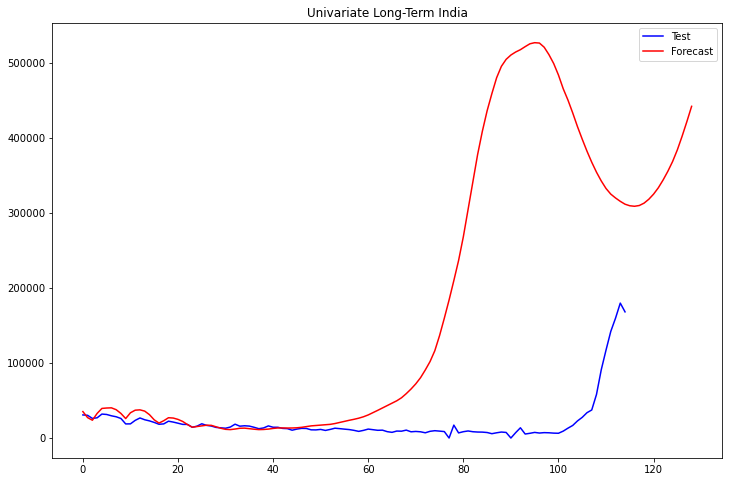

In [642]:
evaluate.plot_fore_test(india_uni_test_np_denorm[timesteps:], yhat_uni_india_denorm, 'Univariate Long-Term India')

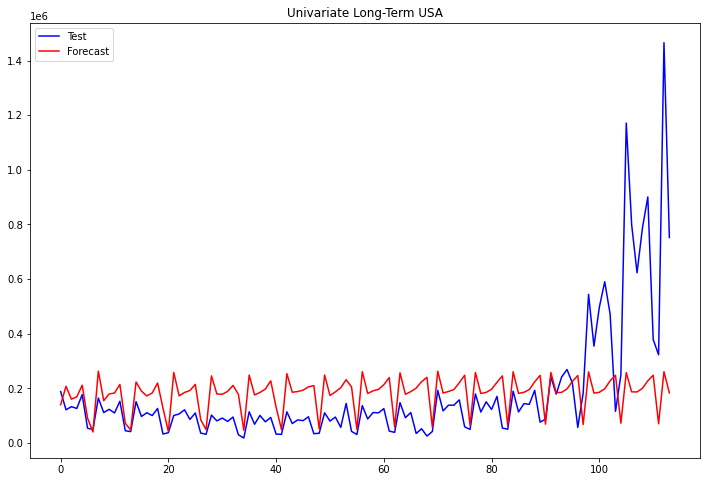

In [643]:
evaluate.plot_fore_test(usa_uni_test_np_denorm[timesteps:], yhat_uni_usa_denorm, 'Univariate Long-Term USA')

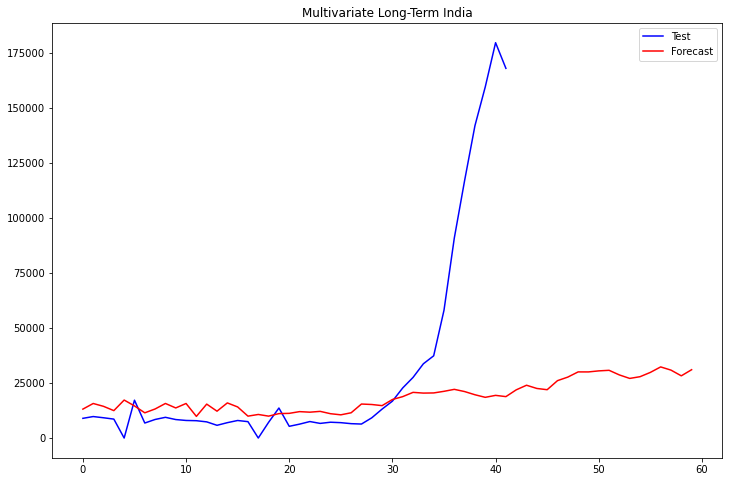

In [644]:
evaluate.plot_fore_test(india_multi_test_np_long_denorm[14:], yhat_multi_india_long_denorm[:60], "Multivariate Long-Term India")

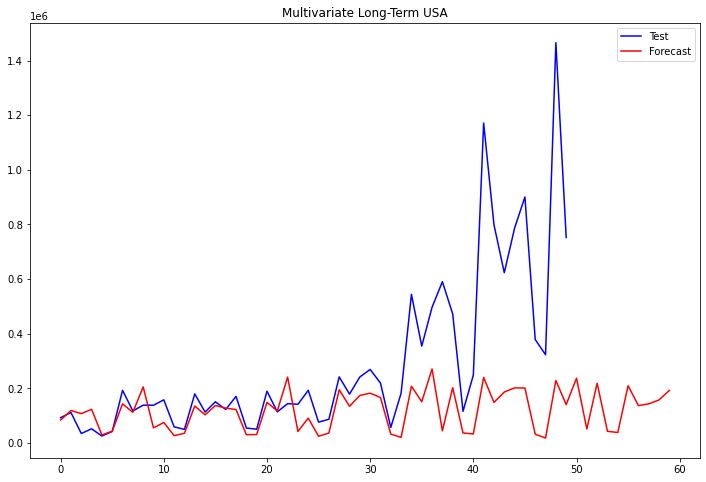

In [645]:
evaluate.plot_fore_test(usa_multi_test_np_long_denorm[14:], yhat_multi_usa_long_denorm[:60], "Multivariate Long-Term USA")

#### Short-Term Rolling Forecast

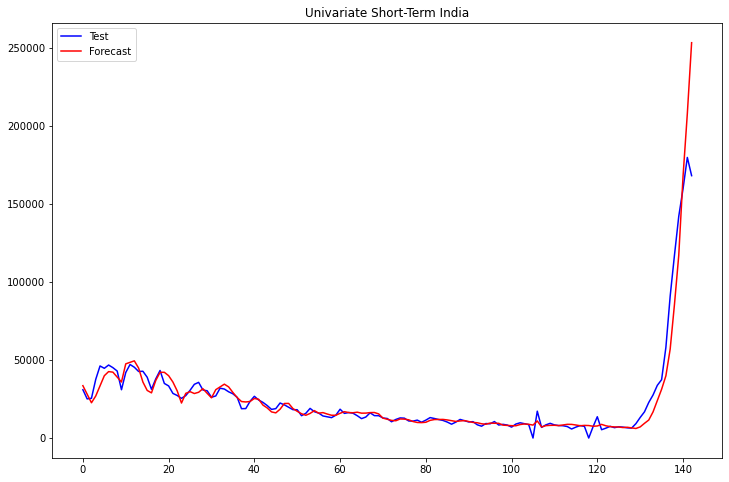

In [646]:
evaluate.plot_fore_test(india_uni_test_short_denorm, yhat_uni_india_short_denorm, "Univariate Short-Term India")

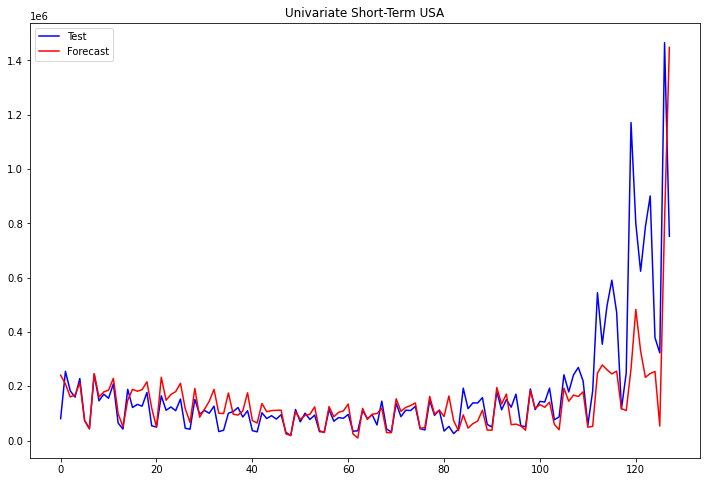

In [647]:
evaluate.plot_fore_test(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm, "Univariate Short-Term USA")

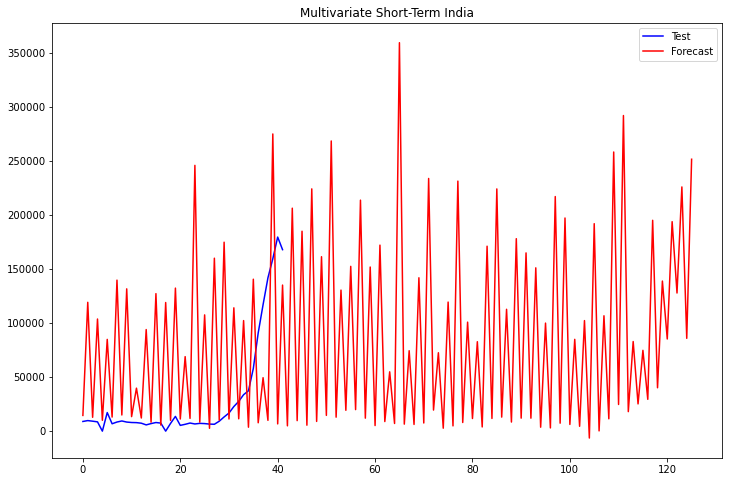

In [648]:
evaluate.plot_fore_test(india_multi_test_np_denorm[14:], yhat_multi_india_denorm, "Multivariate Short-Term India")

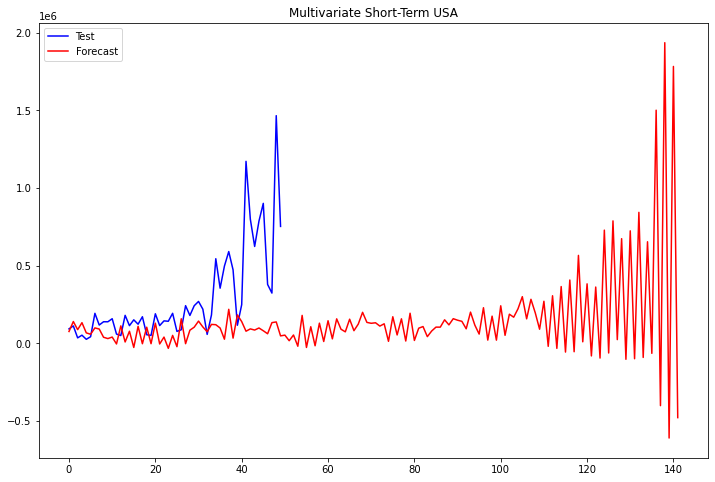

In [649]:
evaluate.plot_fore_test(usa_multi_test_np_denorm[14:], yhat_multi_usa_denorm, "Multivariate Short-Term USA")